In [19]:
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from rasterio.mask import mask
import cartopy.crs as ccrs
from rasterio.plot import show
from rasterio.plot import plotting_extent
from osgeo import gdal, gdal_array
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import pycrs
import xarray as xr
#import georaster
import json
from pathlib import Path
from imblearn.over_sampling import ADASYN

file_dir=('/Users/maddie/Projects/CPSC_597/data')

In [2]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/modified_data/gbif_filtered/taxa_list.txt",header=None)
taxa.columns=["taxon"]

species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/modified_data/gbif_filtered/%s_filtered_data.csv"%i, low_memory=False)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


In [3]:
for key in species_occ_dict:    
#    #load occurrence data and set initial projection
    data=species_occ_dict[key]
    spec = key

    data['coordinates'] = list(zip(data["decimalLongitude"], data["decimalLatitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    data["present/pseudo_absent"]=1
    geo_data=gpd.GeoDataFrame(data, geometry='coordinates',crs='epsg:4326')

    #change projection to azimuthal equidistant to calculate 500m buffer around point
    geo_data = geo_data.to_crs('esri:54032') 
    buffer=geo_data.buffer(0.5*0.5)
    buffer=buffer.to_crs(epsg=4326)

    #create single large polygon from individual buffers
    union_buffer=buffer.unary_union

    #first clip the raster based on this extend 
    raster=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
    
    #specify output tif:
    out_tif = (file_dir+'/modified_data/species_rasters/%s_staccked.tif'%spec)

    #clip the raster:
    out_img, out_transform= mask(dataset=raster,shapes=[union_buffer],crop=True)
   
    # Copy the metadata
    out_meta = raster.meta.copy()

    # Parse EPSG code
    epsg_code = int(raster.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff", "height": out_img.shape[1], "width": out_img.shape[2],"transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)

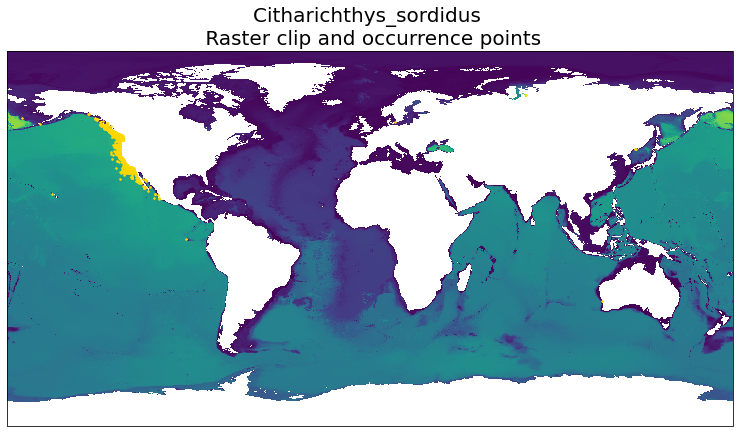

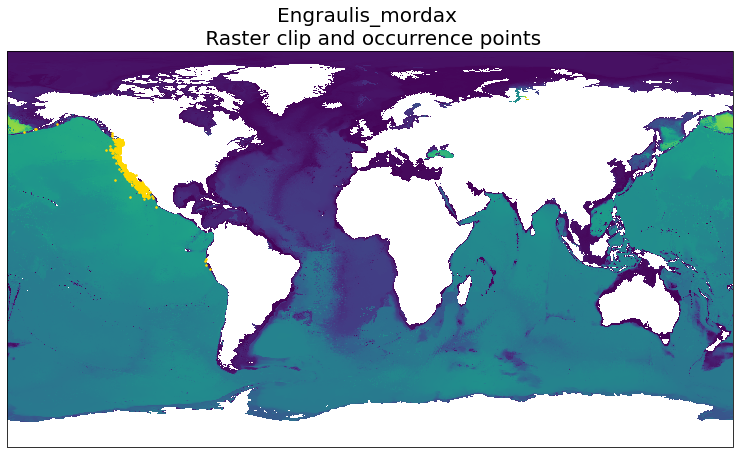

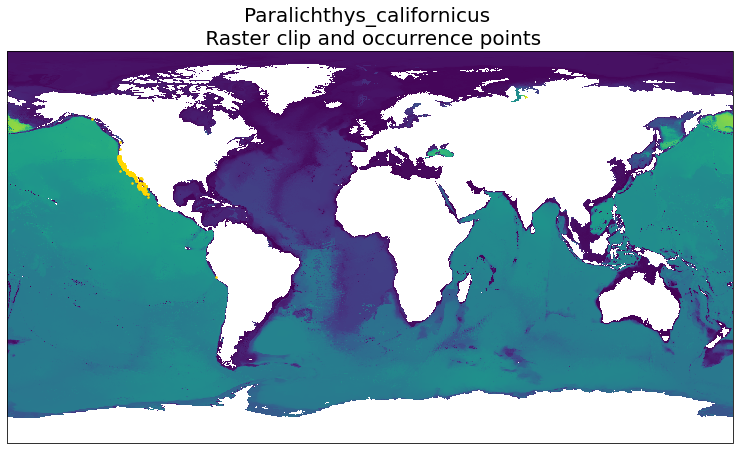

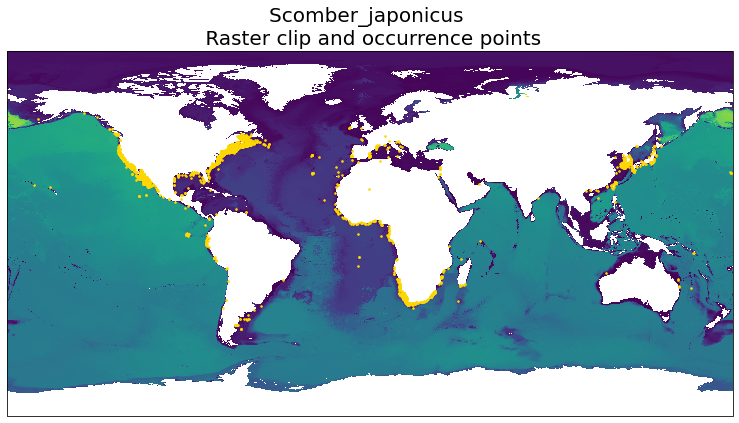

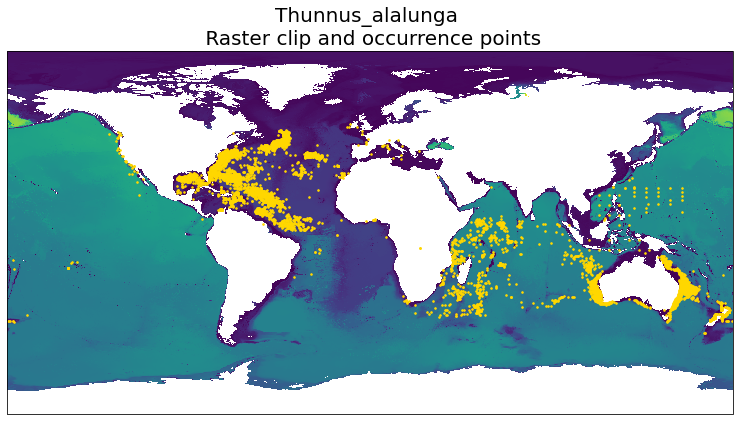

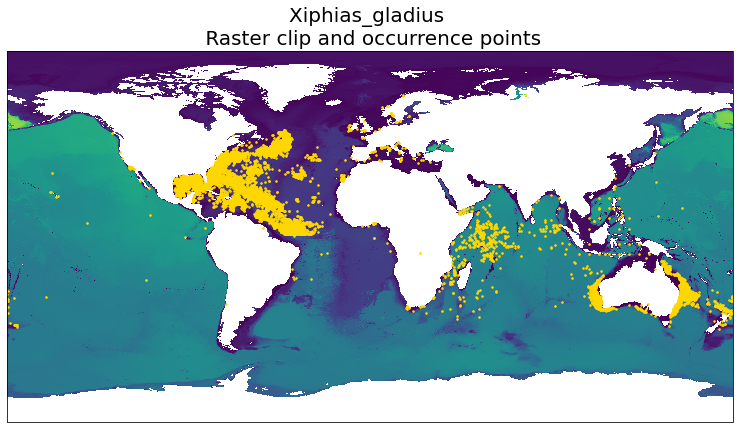

In [4]:
#Inspect the first band of the clipped raster for all species
for key in species_occ_dict:
    
    # Extract occurrence point to plot on the raster (see if correct area was clipped)
    data=species_occ_dict[key]
    spec = key
    data.rename(columns = {'decimalLongitude':'decimal_longitude', 'decimalLatitude':'decimal_latitude',}, inplace = True)
    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    geo_data=gpd.GeoDataFrame(data, geometry='coordinates',crs='epsg:4326')
    
    # open the clipped raster
    clipped = rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_meta = clipped.profile
    
    

    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(1,1,1,projection = ccrs.PlateCarree())
    #ax.stock_img()
    ax.imshow(array_data,interpolation="none",vmin=0,
   
    #Plot the occurrence points on the raster
    extent=plotting_extent(clipped),)
    #ax.set_extent(plotting_extent(clipped))
    spec_plots_points=geo_data["coordinates"]
    spec_plots_points.plot(ax=ax,
                       marker='.',
                       markersize=10,
                       color='#FFD700')
    ax.set_title("%s \n Raster clip and occurrence points"%spec,
             fontsize=20)
    plt.show()
    
#Works!

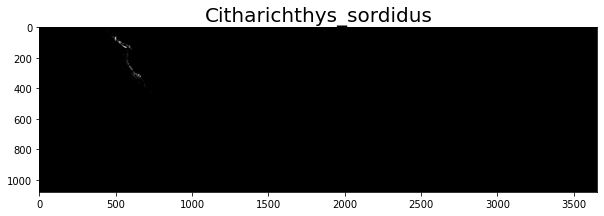

[-139.54166667 -139.79166667 -172.79166667 ... -104.625       -91.375
  115.04166667]
[ 59.625       59.54166667  57.875      ...  18.79166667  -0.29166667
 -30.125     ]


/Users/maddie/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


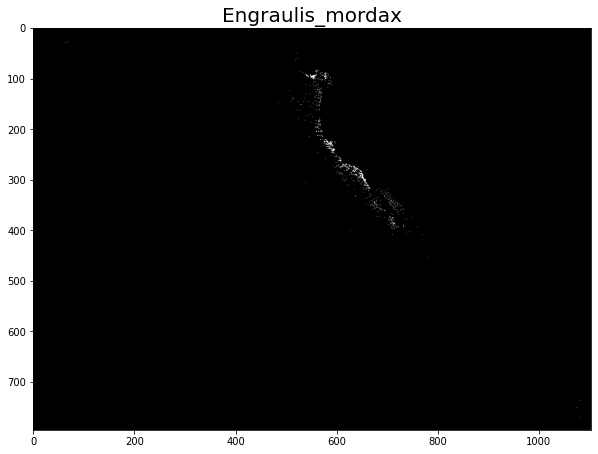

[-155.125      -165.79166667 -166.125      ...  -81.79166667  -81.29166667
  -79.54166667]
[56.79166667 54.54166667 54.375      ... -5.70833333 -7.375
 -9.375     ]


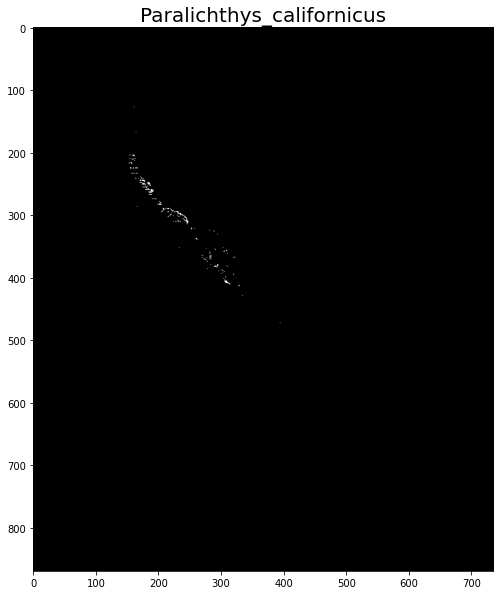

[-137.70833333 -124.29166667 -124.04166667 -124.875      -124.70833333
 -124.45833333 -124.375      -124.29166667 -124.45833333 -124.375
 -124.29166667 -124.20833333 -124.95833333 -124.70833333 -124.45833333
 -124.29166667 -124.125      -124.54166667 -124.375      -124.20833333
 -124.95833333 -124.70833333 -124.625      -124.95833333 -124.70833333
 -124.625      -124.54166667 -124.79166667 -124.70833333 -124.375
 -124.125      -123.95833333 -123.875      -124.79166667 -124.70833333
 -124.45833333 -124.375      -124.125      -123.95833333 -123.875
 -124.625      -124.54166667 -124.375      -124.29166667 -124.04166667
 -123.95833333 -123.79166667 -123.45833333 -123.29166667 -124.125
 -124.04166667 -123.70833333 -123.375      -123.29166667 -123.20833333
 -123.04166667 -123.54166667 -123.45833333 -123.375      -123.20833333
 -123.125      -123.04166667 -122.95833333 -123.45833333 -123.375
 -123.20833333 -123.125      -123.04166667 -122.95833333 -122.875
 -122.95833333 -122.875      -122.45

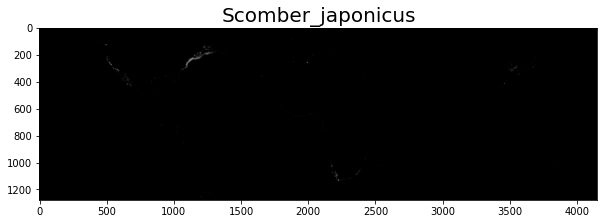

[-141.79166667 -135.70833333 -164.79166667 ...  -66.70833333  -64.04166667
  -64.125     ]
[ 59.29166667  57.375       56.45833333 ... -45.29166667 -47.04166667
 -47.125     ]


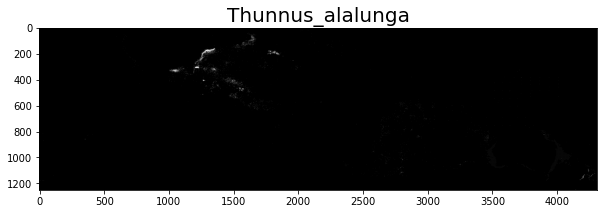

[-10.04166667 -10.125       -6.29166667 ... 166.20833333 166.04166667
 166.20833333]
[ 53.95833333  52.29166667  52.29166667 ... -50.04166667 -50.125
 -50.20833333]


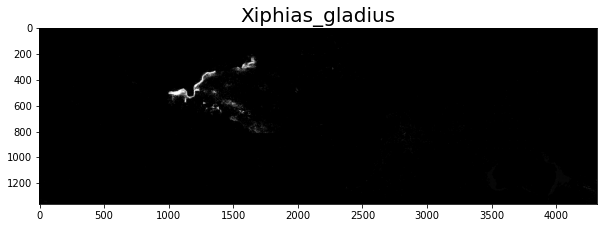

[  16.625        16.29166667    8.375      ...  148.29166667 -175.04166667
  173.125     ]
[ 68.54166667  68.29166667  63.54166667 ... -43.29166667 -44.125
 -44.70833333]


In [5]:
for key in species_occ_dict:  
#        
    presence_data = species_occ_dict[key]
    presence_data.rename(columns = {'decimalLongitude':'decimal_longitude', 'decimalLatitude':'decimal_latitude',}, inplace = True)
    presence_data["present/pseudo_absent"]=1
    spec = key

    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
   
    #read raster
    src=rasterio.open(file_dir+'/modified_data/species_rasters/%s_staccked.tif'%spec)
    array=src.read_masks(1)
    

    
    #set raster cell mask values of presence locations to threshold value (=1) to exclude them from pseudo-absence sampling
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        array[row,col]=1

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array,cmap="gray")
    ax.set_title("%s"%spec,
             fontsize=20)
    plt.show()


    (y_index, x_index) = np.nonzero(array)


    #sample random locations from raster excludin presence cells
    r = gdal.Open(file_dir+'/modified_data/species_rasters/%s_staccked.tif'%spec)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    

    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    print(x_coords)
    print(y_coords)

    lon_lat_array=np.stack((x_coords,y_coords)).T
    random_sample_size= np.random.randint(10000,50000)

    random_sample_lon_lats=lon_lat_array[np.random.choice(lon_lat_array.shape[0], random_sample_size), :] ##
    

    #Add selected cells to dataset
    lon=[]
    lat=[]
    psa=[0]*random_sample_size
    taxon=["%s"%spec]*random_sample_size
    gbif=["no_id"]*random_sample_size

    for item in random_sample_lon_lats:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)
    
  

    #Dataset including occurrences and pseudo-absence points
    new_data=pd.DataFrame({"gbif_id": gbif,"taxon_name":taxon,"decimal_longitude": lon, "decimal_latitude":lat, "present/pseudo_absent": psa})
    data=pd.concat([presence_data,new_data],ignore_index=True)
    data=data[['taxon_name','gbif_id','decimal_longitude','decimal_latitude','present/pseudo_absent']]
    data["taxon_name"]=spec
    data["row_n"]=np.arange(len(data))
     
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
    
    
    
    #read raster
    src=rasterio.open(file_dir+'/modified_data/species_rasters/%s_staccked.tif'%spec)
    array = src.read_masks(1)


    
    data=data.reset_index(drop=True)
    data.to_csv(file_dir + "/modified_data/spec_ppa/%s_ppa_dataframe.csv"%spec)

#next species
    

In [6]:
for key in species_occ_dict:
    
    spec = key
    raster=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
    array = raster.read()
    profile=raster.profile
    
    with open(file_dir+'/modified_data/species_rasters/%s_mean_std.txt'%spec,'w+') as file:
        file.write("band"+"\t"+"mean"+"\t"+"std_dev"+"\n")
        file.close()
    
    min_abs=0
    for band in array:
        minb=np.min(band)    
        if minb < min_abs:
             min_abs=minb

    for i in range(1,10):
        profile.update(count=1)
        band=raster.read(i)
        band[band <= -1000] = min_abs
        
        band_masked = np.ma.masked_array(band, mask=(band == min_abs)) 
        
        mean=band_masked.mean()
        std_dev=np.std(band_masked)


        with open(file_dir+'/modified_data/species_rasters/%s_mean_std.txt'%spec,'a') as file:
              file.write(str(i)+"\t"+str(mean)+"\t"+str(std_dev)+"\n")



In [7]:
raster=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
array = raster.read()
profile=raster.profile

with open(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt','w+') as file:
        file.write("band"+"\t"+"mean"+"\t"+"std_dev"+"\n")
        file.close()
    
min_abs=0
for band in array:
    minb=np.min(band)    
    if minb < min_abs:
        min_abs=minb

for i in range(1,10):
    profile.update(count=1)
    band=raster.read(i)
    band[band <= -1000] = min_abs
        
    band_masked = np.ma.masked_array(band, mask=(band == min_abs)) 
        
    mean=band_masked.mean()
    std_dev=np.std(band_masked)


    with open(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt','a') as file:
            file.write(str(i)+"\t"+str(mean)+"\t"+str(std_dev)+"\n")

In [8]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/modified_data/gbif_filtered/taxa_list.txt",header=None)
taxa.columns=["taxon"]

In [9]:
for i in taxa["taxon"]:
    
    data = pd.read_csv(file_dir+'/modified_data/spec_ppa/%s_ppa_dataframe.csv'%i)
    spec = data["taxon_name"][0]
    spec = spec.replace(" ","_") 
    print("processing species ", spec)
    

    #get all collumn and row numbers
    len_pd=np.arange(len(data))
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    ppa=data["present/pseudo_absent"]



    lon=long.values
    lat=lati.values

    row=[]
    col=[]

    src=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')

    for i in len_pd:
        row_n, col_n = src.index(lon[i], lat[i])# spatial --> image coordinates
        row.append(row_n)
        col.append(col_n)

    ##opening raster as 3d numpy array
    #myarray = gdal_array.LoadFile(file_dir+'/modified_data/species_rasters/%s_stacked.tif'%spec)
    myarray = gdal_array.LoadFile(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
    

    #collect file with mean and std_dev for each band
    mean_std=pd.read_csv(file_dir+'/modified_data/species_rasters/%s_mean_std.txt'%spec,sep="\t")
    mean_std=mean_std.to_numpy()


    ##########################################################
    #extract the values for all bands and prepare input data #
    ##########################################################
    X=[]
    species =["%s"%spec]*int(len(row))

    for j in range(0,9):
        band=myarray[j]
        x=[]

        for i in range(0,len(row)):
            value= band[row[i],col[i]]
            if value <-1000:
                value=np.nan
                x.append(value)
            else:
                value = ((value - mean_std.item((j,1))) / mean_std.item((j,2)))#scale values
                x.append(value)
        X.append(x)


    #set as numpy 2d array
    X =np.array([np.array(xi) for xi in X])

    #transform into dataframe and include row and column values
    df=pd.DataFrame(X)
    df=df.T

    df["present/pseudo_absent"]=ppa
    df["decimal_latitude"]=lati
    df["decimal_longitude"]=long
    df["taxon_name"]=species
    df["present/pseudo_absent"]=ppa
    df["row_n"]=row
    
    #drop any potential rows with no-data values
    df=df.dropna(axis=0, how='any')
    input_data=df
    
    ##save input dataframe
    input_data.to_csv(file_dir +"/modified_data/spec_ppa_env/%s_env_dataframe.csv"%spec)

processing species  Citharichthys_sordidus
processing species  Engraulis_mordax
processing species  Paralichthys_californicus
processing species  Scomber_japonicus
processing species  Thunnus_alalunga
processing species  Xiphias_gladius


In [26]:
data=pd.read_csv(file_dir+'/modified_data/prediction_arrays/locations_to_predict.csv', low_memory= False) #load in data
        
        ###################################################
        # check number of decimals longitude and latitude #
        ###################################################
str_lat=(pd.Series.tolist(data["deci_lat"].astype(str)))
str_lon=(pd.Series.tolist(data["deci_lon"].astype(str)))
dec_lat=[]
dec_lon=[]

for i in range(len(str_lat)):
        if "e" in str_lat[i]:
                str_lat[i]="0.00"
                decla = str_lat[i].split(".")[1]
                dec_lat.append(int(len(decla)))
        else:
                decla = str_lat[i].split(".")[1]
                dec_lat.append(int(len(decla)))
#                
for i in range(len(str_lon)):
        declo=str_lon[i].split(".")[1]
        dec_lon.append(int(len(declo)))
#    
data["dec_lat"]=dec_lat
data["dec_lon"]=dec_lon

        # filter only include those with min. 2 points
data=data[data["dec_lat"] >= 2]
data=data[data["dec_lon"] >= 2]
        
#
        
data['lonlat'] = list(zip(data["deci_lon"], data["deci_lat"]))
data = data.drop_duplicates('lonlat')

filepath = Path(file_dir+'/modified_data/prediction_arrays/world_locations_to_predict.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)  

In [27]:
##opening raster as 3d numpy array
inRas=gdal.Open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
myarray=inRas.ReadAsArray()


#get all collumn and row values for all cells to predict over
df=pd.read_csv(file_dir+'/modified_data/prediction_arrays/world_locations_to_predict.csv')

len_pd=np.arange(len(df))
lon=df["deci_lon"]
lat=df["deci_lat"]
lon=lon.values
lat=lat.values

row=[]
col=[]

src=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')

for i in len_pd:
    row_n, col_n = src.index(lon[i], lat[i])# spatial --> image coordinates
    row.append(row_n)
    col.append(col_n)

#collect file with mean and std_dev for each band
mean_std=pd.read_csv(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt',sep="\t")
mean_std=mean_std.to_numpy()


###########################################################
# extract the values for all bands and prepare input data #
###########################################################
X=[]

for j in range(0,9):
    print(j)
    band=myarray[j]
    x=[]

    for i in range(0,len(row)):
        value= band[row[i],col[i]]
        if value <-1000:
            value=np.nan
            x.append(value)
        else:
            value = ((value - mean_std.item((j,1))) / mean_std.item((j,2))) # scale values
            x.append(value)
    X.append(x)

#include row and column values
X.append(row)
X.append(col)

#set as numpy 2d array
X =np.array([np.array(xi) for xi in X])

df=pd.DataFrame(X)
df=df.T

#drop any rows with no-data values
df=df.dropna(axis=0, how='any')
input_X=df.loc[:,0:8]

row=df[9]
col=df[10]

row_col=pd.DataFrame({"row":row,"col":col})

#convert dataframe back to numpy array
input_X=input_X.values
#convert rows and col indices back to array
row=row.values
col=col.values

#save
prediction_array=np.save(file_dir+'/modified_data/prediction_arrays/world_prediction_array.npy',input_X)
prediction_pandas=row_col.to_csv(file_dir+'/modified_data/prediction_arrays/world_prediction_row_col.csv')

0
1
2
3
4
5
6
7
8
